# Common Test I. Multi-Class Classification

__Task:__ Build a model for classifying the images into lenses using PyTorch or Keras. Pick the most appropriate approach and discuss your strategy.

__Dataset Description:__ The Dataset consists of three classes, strong lensing images with no substructure, subhalo substructure, and vortex substructure. The images have been normalized using min-max normalization, but you are free to use any normalization or data augmentation methods to improve your results.

__Evaluation Metrics:__ ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve) 

The first step is to load the dataset and explore it briefly. This experiment is performed on Google Colab so we have to mount the Google Drive first. 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd /content/gdrive/My Drive/gsoc

/content/gdrive/My Drive/gsoc


In [3]:
!ls

Common_test1_Multi_Class_Classification.ipynb
dataset
__MACOSX
regression_dataset
Specific_test_3_Regression_test.ipynb
trained_models


Let's unzip the data 

In [4]:
#run only first time 
# !unzip \*.zip  && rm *.zip

Import dependencies.

In [210]:
from PIL import Image
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import os
import time

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.models import resnet18,resnet34,resnet50, efficientnet_b1
from torchsummary import summary

from torchvision import transforms, utils, datasets
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score,  roc_curve , classification_report, auc

In [6]:
# initial setup 
# set random seed
np.random.seed(42)
torch.manual_seed(42)

# set matplotlib 
%matplotlib inline
sns.set_style('darkgrid')

Ok!!! Now we should set the device we want to use to train our deep learning model.

In [7]:
# using mac
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
# using CUDA 
elif torch.cuda.is_available():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print (x)  
# using CPU 
else:
    print ("GPU not available.")
    device=torch.device("cpu")

tensor([1.], device='cuda:0')


## Data preprocessing:

First, let's see a few images from our dataset.

In [8]:
# get the current directory 
PATH=os.getcwd()

# image classes
classes=["no","sphere","vort"]

# get the first three images for each class
imgs=[(PATH+"/dataset/train"+f"/{c}"+f"/{i}.npy") for c in classes for i in range(1,4)]
# imgs

In [9]:
PATH

'/content/gdrive/My Drive/gsoc'

Let's see one image

In [10]:
# Slower method

# p=PATH+"/dataset/train/no/1.npy"
# image_data = np.load(p)
# image_data=np.squeeze(image_data, axis=0)

# # Plot the image
# plt.imshow(image_data)
# plt.show()

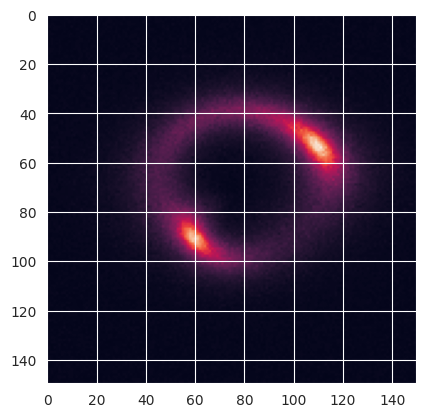

In [11]:
p=PATH+"/dataset/train/no/1.npy"
image_data = np.lib.format.open_memmap(p, dtype='float32',mode="r+")
image_data=np.squeeze(image_data, axis=0)

# Plot the image
plt.imshow(image_data)
plt.show()

Let's see some more images

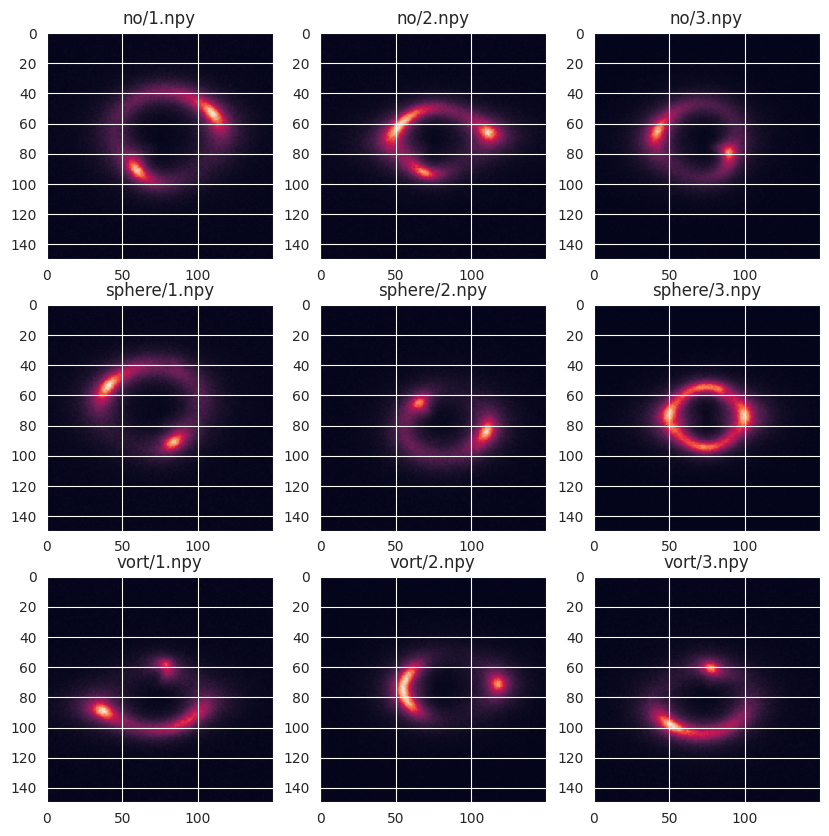

In [12]:
fig, axs = plt.subplots(3, 3, figsize=(10,10))

# plot each image in a subplot
n=0
for i in range(3):
    for j in range(3): 
        image_data = np.lib.format.open_memmap(imgs[n], dtype='float32',mode="r+").squeeze()
        axs[i,j].imshow(image_data)
        axs[i,j].set_title(f"{classes[i]}/{j+1}.npy")
        n+=1
    
# show the figure
plt.show()

Seeing the images above, we can think of some image transforms that can be beneficial in our case for creating a better model.

Let's define the transforms we want to apply to our input images. For our baseline model, we apply some basic image transforms. The `Resize` transform will just resize our image to a custom size . And `ToTensor` transform will convert our input image into tensors. Since the data is already normalized, we do not need to apply the `Normalize` transform.

We also try some other transforms and emperically choose the transforms that give the best performance.

- `CenterCrop`
- `RandomVerticalFlip`
- `RandomHorizontalFlip`
- `RandomRotation`

In [51]:
# image should be what size
IMG_SIZE=(64,64)

image_transforms = {
    "train": transforms.Compose([ 
        transforms.ToTensor(),
        # transforms.Resize(IMG_SIZE),
        transforms.CenterCrop(100),
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation(degrees=(0,360)),
    ]),
    "test": transforms.Compose([
        transforms.ToTensor(),
        transforms.CenterCrop(100)
        ])
        }

### Creating Dataset class:
 
In PyTorch, the `Dataset` class is used to define a custom dataset. A dataset is typically used to load and preprocess the data used for training or testing a machine learning model. There are two main functions that we want to implement in this class:

- `__len__` function: The `__len__()` method returns the number of samples in the dataset, which is the length of the `samples` list.
- `__getitem__` function: The `__getitem__()` method loads the image from the file path specified in `samples`, performs the required transforms and return the image and the label associated with it.




In [14]:
# class LenseImageDataset(datasets.VisionDataset):
    
#     def __init__(self,img_dir, transform=None,target_transform=None):
        
#         """
#         Parameters:
#         img_dir: path of the directory where the dataset is present. 
#                 Something like './dataset/train'
                
#         transform: transform to be applied on the data.
        
#         target_transform: transform to be applied to the target label.
#         """
        
#         self.root=img_dir
#         self.classes=sorted([d.name for d in os.scandir(self.root) if d.is_dir()])
#         self.transform=transform
#         self.target_transform=target_transform
        
#         # create a dictionary mapping class names to indices
#         self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

#         # create a list of image file paths and their corresponding class indices
#         self.samples = []
#         for class_idx, class_name in enumerate(self.classes):
#             class_dir = os.path.join(self.root, class_name)
#             for img_file in os.listdir(class_dir):

#                 img_path = os.path.join(class_dir, img_file)

#                 # load the image data
#                 # img=np.memmap(img_path, mode='r').squeeze()
#                 # img = np.load(img_path).squeeze()

#                 self.samples.append((img_path, class_idx))
    
#     def __len__(self):
        
#         return len(self.samples)

#     def __getitem__(self, idx):
        
#         # get the image path and it's corresponding index
#         img_path, class_idx = self.samples[idx]
# #         print(img_path,class_idx)
        
#         # img = np.load(img_path).squeeze()
#         img=np.lib.format.open_memmap(img_path, dtype='float32',mode="r+").squeeze()
        
#         # perform transform 
#         if self.transform is not None:
#             img = self.transform(img)

#         return img, class_idx

The above `Dataset` is fully functional but has one problem. When we create the dataloader, loading image files from a memory takes a lot of time. This slows down the training significantly. My workaround this is two fold:

- __Image Lookup Matrix__: Instead of loading the image during training in every epoch. We can load the images beforehand and stack them in a numpy array. So, every time we need an image, we can just look it up in the matrix we created before. This makes the data loading process much faster. 
- __Time Bound Loading__: The dataset has 30000 images and loading all of them at a time is simply not possible. It takes a lot of time and compute resources. So, we can constrain the data loading process to a specified time bound. Let's say the time bound is 30 minutes, then we will load as many images possible in 30 minutes and move on to the training process. 

In [15]:
import concurrent.futures

In [16]:
def load_image(i,j):
  
  # load image and return 
  image_data = np.lib.format.open_memmap(PATH+f"/dataset/train/{i}/{j}", dtype='float32',mode="r+")
  return image_data, i  

In the code below, we use python's `concurrent futures` module to parallelize the data loading process. 

In [17]:
TRAINING_IMAGES=np.empty((0, 150, 150)) # empty array 
TRAINING_LABELS=[]

with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor: 

  for i in classes:
    futures=[executor.submit(load_image,i,j) for j in os.listdir(PATH+f"/dataset/train/{i}")] #assigning tasks to threads


    start=time.time()

    # get the class images and labels 
    CLASS_IMAGES= np.empty((0, 150, 150))
    CLASS_LABELS=[] 

    for future in concurrent.futures.as_completed(futures):

      # if this code is running for more than 30 minutes than break
      if time.time()- start >= 600:
        break

      # stack image with the TRAINING_IMAGES list
      try:
        img, label=future.result()

        CLASS_LABELS.append(label)

        CLASS_IMAGES=np.vstack([CLASS_IMAGES,img])

      except:
        pass

    TRAINING_LABELS.extend(CLASS_LABELS)
    TRAINING_IMAGES=np.vstack([TRAINING_IMAGES, CLASS_IMAGES])

print("Sample Created")

Sample Created


How many images did we load?

In [18]:
len(TRAINING_IMAGES)

12130

In [19]:
TESTING_IMAGES=np.empty((0, 150, 150)) # empty array 
TESTING_LABELS=[]

with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor: 

  for i in classes:
    futures=[executor.submit(load_image,i,j) for j in os.listdir(PATH+f"/dataset/val/{i}")] #assigning tasks to threads


    start=time.time()

    # get the class images and labels 
    CLASS_IMAGES= np.empty((0, 150, 150))
    CLASS_LABELS=[] 

    for future in concurrent.futures.as_completed(futures):

      # if this code is running for more than 15 minutes than break
      if time.time()- start >= 300:
        break

      # stack image with the TRAINING_IMAGES list
      try:
        img, label=future.result()

        CLASS_LABELS.append(label)

        CLASS_IMAGES=np.vstack([CLASS_IMAGES,img])

      except:
        pass

    TESTING_LABELS.extend(CLASS_LABELS)
    TESTING_IMAGES=np.vstack([TESTING_IMAGES, CLASS_IMAGES])

print("Sample Created")

Sample Created


How many images did we load?

In [20]:
len(TESTING_IMAGES)

7454

In [21]:
class LenseImageDataset(datasets.VisionDataset):
    
    def __init__(self,img_dir, image_lookup, label_lookup, transform=None,target_transform=None):
        
        """
        Parameters:
        img_dir: path of the directory where the dataset is present. 
                Something like './dataset/train'
                
        transform: transform to be applied on the data.
        
        target_transform: transform to be applied to the target label.
        """
        
        self.root=img_dir
        self.classes=sorted([d.name for d in os.scandir(self.root) if d.is_dir()])
        self.transform=transform
        self.target_transform=target_transform
        self.image_lookup=image_lookup
        self.label_lookup=label_lookup
        
        # create a dictionary mapping class names to indices
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
    
    def __len__(self):
        
        return len(self.image_lookup)

    def __getitem__(self, idx):
        
        # lookup image from stacked array

        img=self.image_lookup[idx]

        # lookup class index from list
        # print(idx)
        # print(self.label_lookup[idx])
        class_idx=self.class_to_idx[self.label_lookup[idx]]
        

        # perform transform 
        if self.transform is not None:
            img = self.transform(img)

        return img, class_idx

### Create Datasets:

Ok! Now let's create our training and testing datasets.

In [234]:
# getting data 
training_data=LenseImageDataset(
    img_dir=PATH+"/dataset/train",
    image_lookup=TRAINING_IMAGES,
    label_lookup=TRAINING_LABELS,
    transform=image_transforms["train"],
)
testing_data=LenseImageDataset(
    img_dir=PATH+"/dataset/val",
    image_lookup=TESTING_IMAGES,
    label_lookup=TESTING_LABELS,
    transform=image_transforms["test"],
    )

If ever we need to reduce the number of train and test samples we can use this piece of code. 

In [235]:
limit=False

if limit:
  train_samples=5000
  test_samples=2500

  subset_indices = random.sample(range(len(training_data)), train_samples)
  training_data = Subset(training_data, subset_indices)

  subset_indices = random.sample(range(len(testing_data)), test_samples)
  testing_data = Subset(testing_data, subset_indices)

### Creating Dataloaders:

In PyTorch, `DataLoader` is a class that provides an iterable over a dataset. It is used to load the data in batches during the training and evaluation of machine learning models.

So, let's create our dataloaders.

In [236]:
# BATCH_SIZE
BATCH_SIZE=128

train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle=True)

# trying to see if we have the right size
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([128, 1, 100, 100])
Labels batch shape: torch.Size([128])


In [237]:
train_labels

tensor([0, 1, 1, 2, 2, 0, 2, 0, 1, 0, 1, 0, 1, 1, 2, 0, 0, 2, 1, 0, 1, 0, 1, 1,
        1, 2, 2, 0, 0, 0, 0, 0, 2, 0, 1, 2, 2, 1, 0, 2, 1, 1, 0, 1, 2, 1, 0, 2,
        1, 1, 0, 0, 1, 0, 1, 2, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 1, 2, 1, 0,
        2, 1, 0, 1, 0, 1, 2, 0, 2, 2, 1, 2, 0, 0, 2, 2, 1, 2, 1, 1, 2, 1, 0, 2,
        2, 2, 2, 0, 0, 1, 1, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 1, 1, 1, 2, 2, 1, 0,
        0, 1, 0, 2, 2, 0, 0, 1])

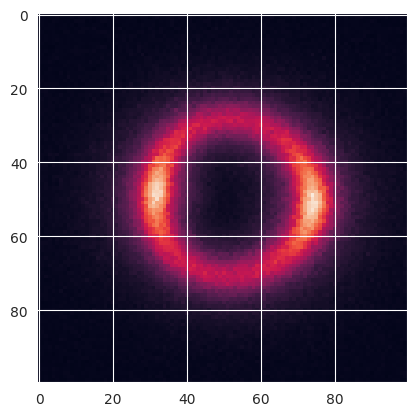

In [238]:
# what do we have after transformation
plt.imshow(train_features[0].cpu().numpy().squeeze())
plt.show()

## Model Training:

Now that we have completed all our data preprocessing. We can move towards training our model and then evaluating it's performance. 

The first step in the training process is to define the model architecture. For this, we are going to utlize transfer learning.

Transfer learning is a technique in machine learning and deep learning where a pre-trained model is used as a starting point for a new task instead of training a model from scratch.

In our case, we are going to use the `ResNet18` architecture to create our image classifier. This allows us to get high performance on a task without the headache of training a model from scratch.

Let's load the pretrained model.

### Define model architecture:

In [239]:
class ResNetGray(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNetGray, self).__init__()
        
        # Load the pre-trained ResNet model
        self.resnet = resnet18()
        
        # Modify the first convolutional layer to accept one channel as input
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Replace the fully connected layer with a new one that matches the number of classes in our problem
        num_features = self.resnet.fc.in_features
        self.resnet.fc=nn.Linear(num_features,num_classes)
        
        for name,param in self.resnet.named_parameters():
          param.requires_grad = True
        
    def forward(self, x):
      return self.resnet(x)

In [240]:
model = ResNetGray()
model = model.to(device)
summary(model, (1,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 75, 75]           3,136
       BatchNorm2d-2           [-1, 64, 75, 75]             128
              ReLU-3           [-1, 64, 75, 75]               0
         MaxPool2d-4           [-1, 64, 38, 38]               0
            Conv2d-5           [-1, 64, 38, 38]          36,864
       BatchNorm2d-6           [-1, 64, 38, 38]             128
              ReLU-7           [-1, 64, 38, 38]               0
            Conv2d-8           [-1, 64, 38, 38]          36,864
       BatchNorm2d-9           [-1, 64, 38, 38]             128
             ReLU-10           [-1, 64, 38, 38]               0
       BasicBlock-11           [-1, 64, 38, 38]               0
           Conv2d-12           [-1, 64, 38, 38]          36,864
      BatchNorm2d-13           [-1, 64, 38, 38]             128
             ReLU-14           [-1, 64,

### Training helper functions:

Define a few helper functions to train the model. 

In [241]:
# Write a method called `train_one_epoch` that runs one step using the optimizer.
def train_one_epoch(train_loader, model, device, optimizer,
                    # scheduler,
                    log_interval, epoch, batch_size):
    model.train()
    losses = []
    metrics=[]
    counter = []
    num_correct=0

    
    for i, (img, label) in enumerate(train_loader):
        img, label = img.to(device), label.to(device)
        img=img.float()

        # ------------------
        # forward pass
        output=model(img)
        # print(label)

        # calculate loss 
        loss= F.nll_loss(F.log_softmax(output,dim=1),label)
        
        #zero all gradients
        optimizer.zero_grad()
        
        #do a backward pass
        loss.backward()
        
        #update weights
        optimizer.step()
        # scheduler.step()
        # print(loss)

        #get training accuracy
        pred = output.max(dim=1)[1]
        num_correct += torch.eq(pred,label).sum().item()


        
        # ------------------
    
        # Record training loss every log_interval and keep counter of total training images seen
        if (i+1) % log_interval == 0:
            losses.append(loss.item())
            counter.append((i * batch_size) + img.size(0) + epoch * len(train_loader.dataset))

            # get output probabilities
            output_prob = torch.nn.functional.softmax(output, dim=1)

            # get predictions
            y_pred = output_prob.detach().cpu().numpy()
            y_true = label.detach().cpu().numpy()

            # calculate roc_auc_score
            # using macro averaging strategy
            roc_auc = roc_auc_score(y_true,y_pred,multi_class="ovr",average="macro",)
            metrics.append(roc_auc)

    return losses, metrics, counter, num_correct

In [242]:
# let's create a method called `test_one_epoch` that evalutes the trained model on the test dataset. 
# Return the average test loss and the number of samples that the model predicts correctly.

def test_one_epoch(test_loader, model, device):

    # put model in evaluation mode
    model.eval()

    # initialize variables
    test_loss = 0
    auc_score=0
    counter=0
    num_correct = 0

    y_acts=[]
    y_preds=[]
    y_pred_probs=[]


    with torch.no_grad():
        for i, (img, label) in enumerate(test_loader):
            img, label = img.to(device), label.to(device)
            img=img.float()
            
            # ------------------
            output = model(img)
            counter+=1
            test_loss += F.nll_loss(F.log_softmax(output,dim=1),label,reduction='sum').item() # loss function goes here
            
            pred = output.max(dim=1)[1] # Get index of largest log-probability and use that as prediction
    
            # how many did we get correct
            num_correct += torch.eq(pred,label).sum().item()

            output_prob = torch.nn.functional.softmax(output, dim=1)
            y_pred = output_prob.detach().cpu().numpy()
            y_true = label.detach().cpu().numpy()


            # calculate AUC score
            auc_score+=roc_auc_score(y_true,y_pred,multi_class="ovr",average="macro",)

            # return actual values , predictions and probabilties
            y_acts.append(label.detach().cpu().numpy())
            y_pred_probs.append(y_pred)
            y_preds.append(pred.detach().cpu().numpy())

            # ------------------

    test_loss /= len(test_loader.dataset)

    return test_loss, auc_score/counter,counter , num_correct ,y_acts, y_preds,y_pred_probs

### Finding appropriate learning rate:

Finding the optimal learning rate in PyTorch is a crucial step in training neural networks. One approach to finding the optimal learning rate is to use the learning rate range test introduced by Leslie N. Smith in his 2015 paper "Cyclical Learning Rates for Training Neural Networks".

In [243]:
# Instantiate optimizer (model was created in previous cell)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

In [244]:
# Define your learning rate schedule
# lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=1.5)

In [245]:
# losses = []
# learning_rates = []
# change_interval=10

# for epoch in range(2):

#     # out model into training
#     model.train()

#     for i, (img, label) in enumerate(train_dataloader):

#         # get image and label
#         img, label = img.to(device), label.to(device)
#         img=img.float()

#         # clear gradients
#         optimizer.zero_grad()

#         # forward pass
#         outputs = model(img)

#         # calculate loss
#         loss = F.nll_loss(F.log_softmax(outputs,dim=1),label)

#         # backward pass
#         loss.backward()

#         # update weights
#         optimizer.step()

#         # update learning rate
#         if (i+1) % change_interval == 0:
#           lr_scheduler.step()

#         # record loss and learning rate
#         losses.append(loss.item())
#         learning_rates.append(lr_scheduler.get_last_lr())

        

In [246]:
# import matplotlib.pyplot as plt
# plt.plot(learning_rates[:350], losses[:350])
# plt.xlabel('Learning Rate')
# plt.ylabel('Loss')
# plt.xscale('log')
# plt.show()

### Training the model

In [262]:
# Hyperparameters 
log_interval = 10
max_epochs= 50
lr=3e-4 #this is the maximum learning rate I should use
max_lr=3e-3

In [263]:
# initialize model again 
model = ResNetGray()
model = model.to(device)

In [264]:
# Instantiate optimizer (model was created in previous cell)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [265]:
# Define your learning rate schedule
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0 = 15, T_mult = 1,eta_min = 1e-6, verbose=True)

Epoch 00000: adjusting learning rate of group 0 to 3.0000e-04.


In [266]:
train_losses = []
test_losses = []

train_counters = []
test_counters =[]

train_correct=[]
test_correct=[]

train_auc_scores=[]
test_auc_scores=[]

y_preds=[]
y_trues=[]
y_probs=[]


for epoch in trange(max_epochs, leave=True, desc='Epochs'):
    epoch_start=time.time()

    # train one epoch
    train_loss,train_auc_score, train_counter, num_correct= train_one_epoch(train_dataloader, 
                                          model,
                                          device,
                                          optimizer,
                                          # lr_scheduler,
                                          log_interval,
                                          epoch,
                                          BATCH_SIZE,
                                          )
    
    # test one epoch
    test_loss,test_auc_score, test_counter, t_correct, y_true, y_pred, y_prob= test_one_epoch(test_dataloader, 
                              model,
                              device)
    print(f'Time taken for the epoch:{time.time()-epoch_start}')

    # learning rate step
    lr_scheduler.step()

    # Record results
    print("--"*20)
    print(f"Training loss for epoch {epoch+1} :{train_loss[0]}")
    print(f"Testing loss for epoch {epoch+1} : {test_loss}")
    train_losses.extend(train_loss)
    train_counters.extend(train_counter)
    test_counters.append(test_counter)
    test_losses.append(test_loss)
    
    train_correct.append(num_correct)
    test_correct.append(t_correct)

    train_auc_scores.extend(train_auc_score)
    test_auc_scores.append(test_auc_score)

    y_preds.append(y_pred)
    y_trues.append(y_true)
    y_probs.append(y_prob)


print("\n")
print(f"Train accuracy: {train_correct[-1]/len(train_dataloader.dataset):0.4f}") 
print(f"Test accuracy: {test_correct[-1]/len(test_dataloader.dataset)}")

Epochs:   2%|▏         | 1/50 [00:14<11:39, 14.28s/it]

Time taken for the epoch:14.281025648117065
Epoch 00001: adjusting learning rate of group 0 to 2.9673e-04.
----------------------------------------
Training loss for epoch 1 :1.0641671419143677
Testing loss for epoch 1 : 1.1325824723219404


Epochs:   4%|▍         | 2/50 [00:28<11:22, 14.22s/it]

Time taken for the epoch:14.174595594406128
Epoch 00002: adjusting learning rate of group 0 to 2.8708e-04.
----------------------------------------
Training loss for epoch 2 :1.1506471633911133
Testing loss for epoch 2 : 1.1076201947342463


Epochs:   6%|▌         | 3/50 [00:42<11:00, 14.05s/it]

Time taken for the epoch:13.831308603286743
Epoch 00003: adjusting learning rate of group 0 to 2.7145e-04.
----------------------------------------
Training loss for epoch 3 :1.1005619764328003
Testing loss for epoch 3 : 1.112696015358227


Epochs:   8%|▊         | 4/50 [00:56<10:57, 14.29s/it]

Time taken for the epoch:14.655572891235352
Epoch 00004: adjusting learning rate of group 0 to 2.5054e-04.
----------------------------------------
Training loss for epoch 4 :1.126781940460205
Testing loss for epoch 4 : 1.1174835095560387


Epochs:  10%|█         | 5/50 [01:11<10:44, 14.33s/it]

Time taken for the epoch:14.407915115356445
Epoch 00005: adjusting learning rate of group 0 to 2.2525e-04.
----------------------------------------
Training loss for epoch 5 :1.108545184135437
Testing loss for epoch 5 : 1.0999164478945802


Epochs:  12%|█▏        | 6/50 [01:25<10:20, 14.10s/it]

Time taken for the epoch:13.654537916183472
Epoch 00006: adjusting learning rate of group 0 to 1.9670e-04.
----------------------------------------
Training loss for epoch 6 :1.0973737239837646
Testing loss for epoch 6 : 1.3059225187309311


Epochs:  14%|█▍        | 7/50 [01:38<09:55, 13.86s/it]

Time taken for the epoch:13.351786613464355
Epoch 00007: adjusting learning rate of group 0 to 1.6613e-04.
----------------------------------------
Training loss for epoch 7 :1.0562220811843872
Testing loss for epoch 7 : 1.078716706423584


Epochs:  16%|█▌        | 8/50 [01:53<09:57, 14.24s/it]

Time taken for the epoch:15.04716444015503
Epoch 00008: adjusting learning rate of group 0 to 1.3487e-04.
----------------------------------------
Training loss for epoch 8 :1.07072114944458
Testing loss for epoch 8 : 1.064242264461287


Epochs:  18%|█▊        | 9/50 [02:06<09:34, 14.02s/it]

Time taken for the epoch:13.521635055541992
Epoch 00009: adjusting learning rate of group 0 to 1.0430e-04.
----------------------------------------
Training loss for epoch 9 :1.0191422700881958
Testing loss for epoch 9 : 2.072333921591654


Epochs:  20%|██        | 10/50 [02:21<09:28, 14.21s/it]

Time taken for the epoch:14.653311014175415
Epoch 00010: adjusting learning rate of group 0 to 7.5750e-05.
----------------------------------------
Training loss for epoch 10 :1.026716709136963
Testing loss for epoch 10 : 1.507415324713418


Epochs:  22%|██▏       | 11/50 [02:35<09:13, 14.18s/it]

Time taken for the epoch:14.106448888778687
Epoch 00011: adjusting learning rate of group 0 to 5.0465e-05.
----------------------------------------
Training loss for epoch 11 :0.9712730050086975
Testing loss for epoch 11 : 1.0322276589567871


Epochs:  24%|██▍       | 12/50 [02:50<09:06, 14.39s/it]

Time taken for the epoch:14.858596324920654
Epoch 00012: adjusting learning rate of group 0 to 2.9552e-05.
----------------------------------------
Training loss for epoch 12 :0.9476485252380371
Testing loss for epoch 12 : 0.9771348788458699


Epochs:  26%|██▌       | 13/50 [03:05<08:56, 14.50s/it]

Time taken for the epoch:14.740423202514648
Epoch 00013: adjusting learning rate of group 0 to 1.3925e-05.
----------------------------------------
Training loss for epoch 13 :0.912464439868927
Testing loss for epoch 13 : 0.9363250957598531


Epochs:  28%|██▊       | 14/50 [03:19<08:42, 14.51s/it]

Time taken for the epoch:14.51557183265686
Epoch 00014: adjusting learning rate of group 0 to 4.2669e-06.
----------------------------------------
Training loss for epoch 14 :0.8530917763710022
Testing loss for epoch 14 : 0.9280866411054042


Epochs:  30%|███       | 15/50 [03:34<08:27, 14.49s/it]

Time taken for the epoch:14.431791305541992
Epoch 00015: adjusting learning rate of group 0 to 3.0000e-04.
----------------------------------------
Training loss for epoch 15 :0.8322630524635315
Testing loss for epoch 15 : 0.8781461421433293


Epochs:  32%|███▏      | 16/50 [03:48<08:07, 14.33s/it]

Time taken for the epoch:13.964093685150146
Epoch 00016: adjusting learning rate of group 0 to 2.9673e-04.
----------------------------------------
Training loss for epoch 16 :0.9697452187538147
Testing loss for epoch 16 : 2.137877651856353


Epochs:  34%|███▍      | 17/50 [04:02<07:56, 14.44s/it]

Time taken for the epoch:14.686527729034424
Epoch 00017: adjusting learning rate of group 0 to 2.8708e-04.
----------------------------------------
Training loss for epoch 17 :0.8975772261619568
Testing loss for epoch 17 : 1.7339617624531043


Epochs:  36%|███▌      | 18/50 [04:16<07:32, 14.13s/it]

Time taken for the epoch:13.398402214050293
Epoch 00018: adjusting learning rate of group 0 to 2.7145e-04.
----------------------------------------
Training loss for epoch 18 :0.8850870728492737
Testing loss for epoch 18 : 1.1544086122627966


Epochs:  38%|███▊      | 19/50 [04:31<07:22, 14.29s/it]

Time taken for the epoch:14.651867151260376
Epoch 00019: adjusting learning rate of group 0 to 2.5054e-04.
----------------------------------------
Training loss for epoch 19 :0.7896834015846252
Testing loss for epoch 19 : 1.286210274293335


Epochs:  40%|████      | 20/50 [04:45<07:09, 14.33s/it]

Time taken for the epoch:14.429170846939087
Epoch 00020: adjusting learning rate of group 0 to 2.2525e-04.
----------------------------------------
Training loss for epoch 20 :0.8480768799781799
Testing loss for epoch 20 : 2.0791692454852653


Epochs:  42%|████▏     | 21/50 [04:59<06:53, 14.26s/it]

Time taken for the epoch:14.084378719329834
Epoch 00021: adjusting learning rate of group 0 to 1.9670e-04.
----------------------------------------
Training loss for epoch 21 :0.7775956988334656
Testing loss for epoch 21 : 1.0139808567785085


Epochs:  44%|████▍     | 22/50 [05:13<06:38, 14.24s/it]

Time taken for the epoch:14.199480533599854
Epoch 00022: adjusting learning rate of group 0 to 1.6613e-04.
----------------------------------------
Training loss for epoch 22 :0.7633732557296753
Testing loss for epoch 22 : 1.132315891307834


Epochs:  46%|████▌     | 23/50 [05:28<06:25, 14.29s/it]

Time taken for the epoch:14.38149094581604
Epoch 00023: adjusting learning rate of group 0 to 1.3487e-04.
----------------------------------------
Training loss for epoch 23 :0.6630131006240845
Testing loss for epoch 23 : 1.3620291679961642


Epochs:  48%|████▊     | 24/50 [05:41<06:05, 14.07s/it]

Time taken for the epoch:13.550456285476685
Epoch 00024: adjusting learning rate of group 0 to 1.0430e-04.
----------------------------------------
Training loss for epoch 24 :0.640100359916687
Testing loss for epoch 24 : 2.6312407607970814


Epochs:  50%|█████     | 25/50 [05:55<05:46, 13.84s/it]

Time taken for the epoch:13.314754486083984
Epoch 00025: adjusting learning rate of group 0 to 7.5750e-05.
----------------------------------------
Training loss for epoch 25 :0.795850396156311
Testing loss for epoch 25 : 1.2061279190427854


Epochs:  52%|█████▏    | 26/50 [06:08<05:28, 13.67s/it]

Time taken for the epoch:13.253859758377075
Epoch 00026: adjusting learning rate of group 0 to 5.0465e-05.
----------------------------------------
Training loss for epoch 26 :0.5264946222305298
Testing loss for epoch 26 : 0.9378396324155668


Epochs:  54%|█████▍    | 27/50 [06:21<05:11, 13.55s/it]

Time taken for the epoch:13.275432586669922
Epoch 00027: adjusting learning rate of group 0 to 2.9552e-05.
----------------------------------------
Training loss for epoch 27 :0.5271680951118469
Testing loss for epoch 27 : 1.8951773299331605


Epochs:  56%|█████▌    | 28/50 [06:34<04:55, 13.45s/it]

Time taken for the epoch:13.197184801101685
Epoch 00028: adjusting learning rate of group 0 to 1.3925e-05.
----------------------------------------
Training loss for epoch 28 :0.6124488711357117
Testing loss for epoch 28 : 0.7252455875897235


Epochs:  58%|█████▊    | 29/50 [06:48<04:41, 13.39s/it]

Time taken for the epoch:13.24090051651001
Epoch 00029: adjusting learning rate of group 0 to 4.2669e-06.
----------------------------------------
Training loss for epoch 29 :0.5684333443641663
Testing loss for epoch 29 : 0.7814239510141368


Epochs:  60%|██████    | 30/50 [07:01<04:26, 13.35s/it]

Time taken for the epoch:13.257461786270142
Epoch 00030: adjusting learning rate of group 0 to 3.0000e-04.
----------------------------------------
Training loss for epoch 30 :0.37911635637283325
Testing loss for epoch 30 : 0.7344350336318941


Epochs:  62%|██████▏   | 31/50 [07:14<04:13, 13.34s/it]

Time taken for the epoch:13.322678804397583
Epoch 00031: adjusting learning rate of group 0 to 2.9673e-04.
----------------------------------------
Training loss for epoch 31 :0.7350710034370422
Testing loss for epoch 31 : 4.774788254926439


Epochs:  64%|██████▍   | 32/50 [07:28<04:00, 13.37s/it]

Time taken for the epoch:13.422444343566895
Epoch 00032: adjusting learning rate of group 0 to 2.8708e-04.
----------------------------------------
Training loss for epoch 32 :0.6468771696090698
Testing loss for epoch 32 : 1.7157280924238978


Epochs:  66%|██████▌   | 33/50 [07:41<03:47, 13.37s/it]

Time taken for the epoch:13.373961448669434
Epoch 00033: adjusting learning rate of group 0 to 2.7145e-04.
----------------------------------------
Training loss for epoch 33 :0.6173911690711975
Testing loss for epoch 33 : 0.961686741291821


Epochs:  68%|██████▊   | 34/50 [07:54<03:34, 13.38s/it]

Time taken for the epoch:13.404345035552979
Epoch 00034: adjusting learning rate of group 0 to 2.5054e-04.
----------------------------------------
Training loss for epoch 34 :0.5397257208824158
Testing loss for epoch 34 : 1.3469768428981608


Epochs:  70%|███████   | 35/50 [08:08<03:20, 13.38s/it]

Time taken for the epoch:13.368138551712036
Epoch 00035: adjusting learning rate of group 0 to 2.2525e-04.
----------------------------------------
Training loss for epoch 35 :0.5136457681655884
Testing loss for epoch 35 : 1.0530764812881965


Epochs:  72%|███████▏  | 36/50 [08:21<03:07, 13.36s/it]

Time taken for the epoch:13.318494081497192
Epoch 00036: adjusting learning rate of group 0 to 1.9670e-04.
----------------------------------------
Training loss for epoch 36 :0.44632336497306824
Testing loss for epoch 36 : 0.6865994980804141


Epochs:  74%|███████▍  | 37/50 [08:34<02:53, 13.35s/it]

Time taken for the epoch:13.309082508087158
Epoch 00037: adjusting learning rate of group 0 to 1.6613e-04.
----------------------------------------
Training loss for epoch 37 :0.4053100645542145
Testing loss for epoch 37 : 0.9368103120485003


Epochs:  76%|███████▌  | 38/50 [08:48<02:40, 13.34s/it]

Time taken for the epoch:13.32384991645813
Epoch 00038: adjusting learning rate of group 0 to 1.3487e-04.
----------------------------------------
Training loss for epoch 38 :0.4236263930797577
Testing loss for epoch 38 : 0.6307891467508695


Epochs:  78%|███████▊  | 39/50 [09:01<02:26, 13.35s/it]

Time taken for the epoch:13.371302843093872
Epoch 00039: adjusting learning rate of group 0 to 1.0430e-04.
----------------------------------------
Training loss for epoch 39 :0.3351099491119385
Testing loss for epoch 39 : 0.6702853065410888


Epochs:  80%|████████  | 40/50 [09:14<02:13, 13.35s/it]

Time taken for the epoch:13.354713201522827
Epoch 00040: adjusting learning rate of group 0 to 7.5750e-05.
----------------------------------------
Training loss for epoch 40 :0.5338342785835266
Testing loss for epoch 40 : 0.6780574804725166


Epochs:  82%|████████▏ | 41/50 [09:28<02:00, 13.34s/it]

Time taken for the epoch:13.301580667495728
Epoch 00041: adjusting learning rate of group 0 to 5.0465e-05.
----------------------------------------
Training loss for epoch 41 :0.3304055631160736
Testing loss for epoch 41 : 0.6077842075254759


Epochs:  84%|████████▍ | 42/50 [09:41<01:46, 13.33s/it]

Time taken for the epoch:13.322858095169067
Epoch 00042: adjusting learning rate of group 0 to 2.9552e-05.
----------------------------------------
Training loss for epoch 42 :0.1956014782190323
Testing loss for epoch 42 : 0.6719863109624447


Epochs:  86%|████████▌ | 43/50 [09:54<01:33, 13.33s/it]

Time taken for the epoch:13.321197032928467
Epoch 00043: adjusting learning rate of group 0 to 1.3925e-05.
----------------------------------------
Training loss for epoch 43 :0.16836999356746674
Testing loss for epoch 43 : 0.6577500073878414


Epochs:  88%|████████▊ | 44/50 [10:08<01:19, 13.33s/it]

Time taken for the epoch:13.328219890594482
Epoch 00044: adjusting learning rate of group 0 to 4.2669e-06.
----------------------------------------
Training loss for epoch 44 :0.17134758830070496
Testing loss for epoch 44 : 0.6700020262470251


Epochs:  90%|█████████ | 45/50 [10:21<01:06, 13.34s/it]

Time taken for the epoch:13.347336769104004
Epoch 00045: adjusting learning rate of group 0 to 3.0000e-04.
----------------------------------------
Training loss for epoch 45 :0.13545441627502441
Testing loss for epoch 45 : 0.6466476605729824


Epochs:  92%|█████████▏| 46/50 [10:34<00:53, 13.34s/it]

Time taken for the epoch:13.332795143127441
Epoch 00046: adjusting learning rate of group 0 to 2.9673e-04.
----------------------------------------
Training loss for epoch 46 :0.47488564252853394
Testing loss for epoch 46 : 0.88487707720962


Epochs:  94%|█████████▍| 47/50 [10:48<00:40, 13.35s/it]

Time taken for the epoch:13.380532503128052
Epoch 00047: adjusting learning rate of group 0 to 2.8708e-04.
----------------------------------------
Training loss for epoch 47 :0.4093601405620575
Testing loss for epoch 47 : 1.7734217391693468


Epochs:  96%|█████████▌| 48/50 [11:01<00:26, 13.37s/it]

Time taken for the epoch:13.409454107284546
Epoch 00048: adjusting learning rate of group 0 to 2.7145e-04.
----------------------------------------
Training loss for epoch 48 :0.28034836053848267
Testing loss for epoch 48 : 1.2987330620686106


Epochs:  98%|█████████▊| 49/50 [11:15<00:13, 13.37s/it]

Time taken for the epoch:13.373419046401978
Epoch 00049: adjusting learning rate of group 0 to 2.5054e-04.
----------------------------------------
Training loss for epoch 49 :0.4511009156703949
Testing loss for epoch 49 : 1.1209536875608879


Epochs: 100%|██████████| 50/50 [11:28<00:00, 13.77s/it]

Time taken for the epoch:13.353855609893799
Epoch 00050: adjusting learning rate of group 0 to 2.2525e-04.
----------------------------------------
Training loss for epoch 50 :0.2844236493110657
Testing loss for epoch 50 : 0.6427343090641808


Train accuracy: 0.8657
Test accuracy: 0.7334317145156962


Let's see what the prediction looks like.

In [267]:
train_features=train_features.to(device)
train_labels=train_labels.to(device)

print(f"Prediction:{nn.Softmax(dim=-1)(model(train_features.float())[3]).max(dim=0)[1]}")
print(f"Actual:{train_labels[3].item()}")

Prediction:2
Actual:2


Save the model

In [268]:
# save the model for inference later
torch.save(model.state_dict(),PATH +"/trained_models/resnet18_50epochs_12k.pt")

What does our loss curve look like?

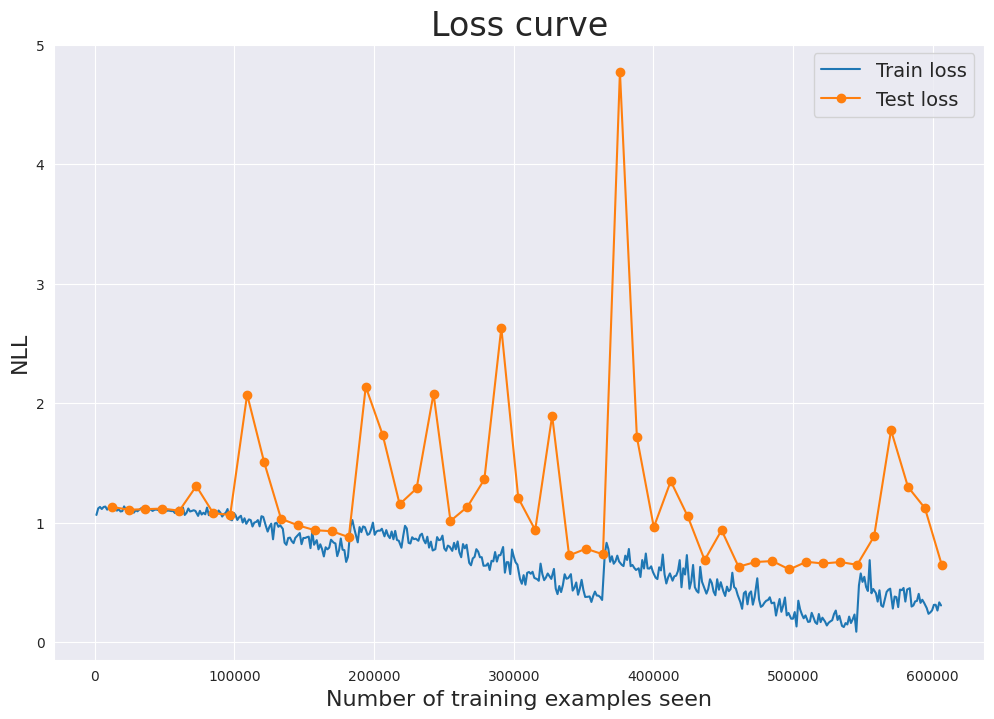

In [269]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
plt.plot(train_counters, train_losses, label='Train loss')
plt.plot([i * len(train_dataloader.dataset) for i in range(1, max_epochs + 1)], 
         test_losses, label='Test loss', marker='o')
plt.title('Loss curve', fontsize=24)
plt.xlabel('Number of training examples seen', fontsize=16)
plt.ylabel('NLL', fontsize=16)
plt.legend(loc='upper right', fontsize=14)

## Model Evaluation

How does the AUC score change as the training goes on?

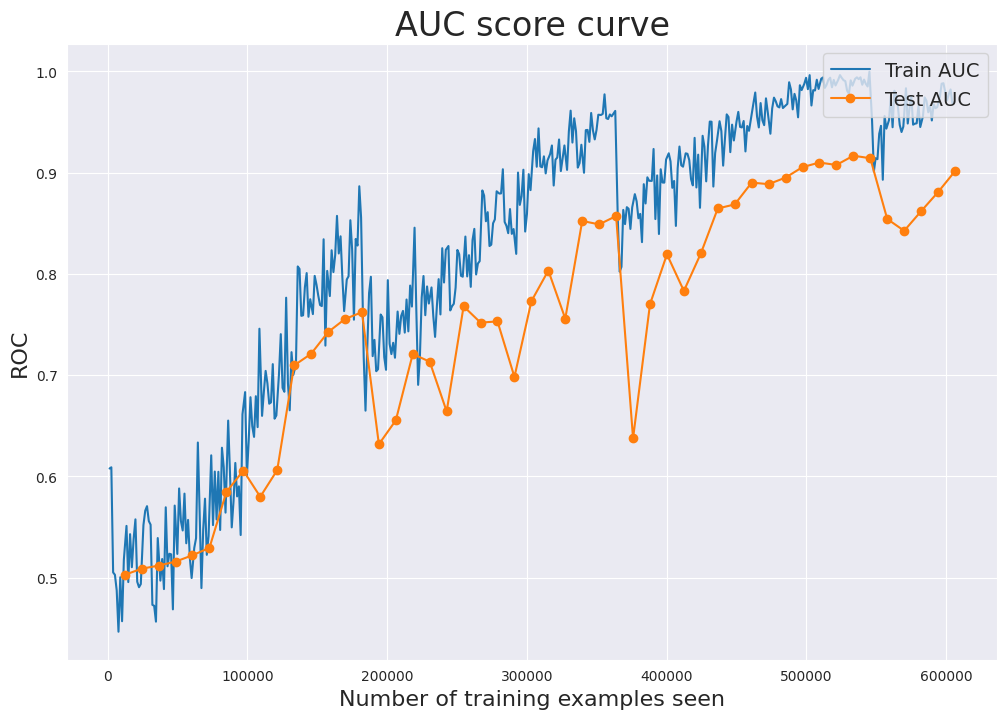

In [270]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
plt.plot(train_counters, train_auc_scores, label='Train AUC')
plt.plot([i * len(train_dataloader.dataset) for i in range(1, max_epochs + 1)],\
         test_auc_scores, label='Test AUC', marker='o')
plt.title('AUC score curve', fontsize=24)
plt.xlabel('Number of training examples seen', fontsize=16)
plt.ylabel('ROC', fontsize=16)
plt.legend(loc='upper right', fontsize=14)

Let's see some more metrics that will give us a better picture of the model performance 

In [271]:
test_loss,test_auc_score, test_counter, t_correct, y_true, y_pred, y_prob= test_one_epoch(test_dataloader, 
                              model,
                              device)

In [272]:
def flatten(l):
  return [item for sublist in l for item in sublist]

In [273]:
y_pred=flatten(y_pred)
y_true=flatten(y_true)
y_prob=flatten(y_prob)

Classification Report 

In [274]:
print(classification_report(y_true, y_pred,target_names =training_data.classes))

              precision    recall  f1-score   support

          no       0.87      0.76      0.81      2464
      sphere       0.62      0.74      0.67      2500
        vort       0.76      0.70      0.73      2490

    accuracy                           0.73      7454
   macro avg       0.75      0.73      0.74      7454
weighted avg       0.75      0.73      0.74      7454



Confusion Matrix

<Axes: >

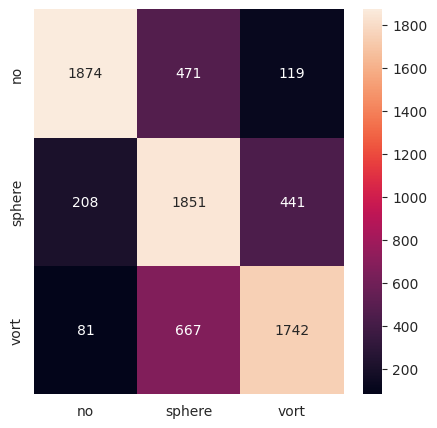

In [275]:
names={0:'no',
       1:'sphere',
       2:'vort'}

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true, y_pred)).rename(columns=names, index=names)
fig, ax = plt.subplots(figsize=(5,5))         
sns.heatmap(confusion_matrix_df, fmt = ".0f", annot=True, ax=ax)

Final AUC score

In [276]:
roc_auc_score(y_true, y_prob, average='macro', multi_class="ovr")

0.9015773781312264

## Conclusion:

In this notebook, an image classification model is presented which can be used for classifying the images into lenses. 

We accomplished this task using the pretrained `ResNet18` architecture. Using transfer learning allows us to get  a better performance on the dataset without the headache of training  a model from scratch.

Following are the hyperparameters used for the training:
- __Image size__: (150,150)
- __Batch size:__ 128
- __Epochs:__ 50
- __Learning rate:__ 3e-4
- __Optimizer:__ Adam

The model performance and the results can be seen in the previous section named `Model Evaluation`.